# Описание проекта

Нужно разобраться, как ведут себя пользователи мобильного приложения в стартапе, который продает продукты питания.  
  
Изучим воронку продаж, узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько - "застревает" на предыдущих шагах? На каких именно?  
  
После этого исследуем результаты A/A/B эксперимента. Выясним, какой шрифт в приложении лучше.  

## План работы
**Часть 1**
- [x] Открыть файл и изучить общую информацию

**Часть 2**
- [x] Переименовать столбцы
- [x] Проверить пропуски и типы данных.
- [x] Добавить столбец даты и времени и столбец даты

**Часть 3**
- [x] Сколько всего событий в логе?
- [x] Сколько всего пользователей в логе?
- [x] Сколько в среднем событий приходится на пользователя?
- [x] Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого  — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?
- [x] Много ли событий и пользователей вы потеряли, отбросив старые данные?
- [x] Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

**Часть 4**
- [x] Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.
- [x] Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.
- [x] Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.
- [x] По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.
- [x] На каком шаге теряете больше всего пользователей?
- [x] Какая доля пользователей доходит от первого события до оплаты?

**Часть 5**
- [x] Сколько пользователей в каждой экспериментальной группе?
- [x] Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.
- [x] Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?
- [x] Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?
- [x] Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

**Часть 6**
- [x] Вывод



## Откроем файл и изучим общую информацию

In [198]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math
import plotly.express as px

In [199]:
try:
    data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    data = pd.read_csv('logs_exp.csv', sep='\t')

In [200]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [201]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


## Изучим и проверим данные

In [202]:
data.columns = ['event_name', 'device_id', 'timestamp', 'exp_id']


In [203]:
data['exp_id'].unique()

array([246, 248, 247])

Пропуски отсутствуют, типы данных соответствуют

In [204]:
data['datetime'] = pd.to_datetime(data['timestamp'], unit='s')


In [205]:
data['date'] = pd.to_datetime(data['datetime'].dt.date)

In [206]:
def get_group(row):
    if row[3] == 246:
        return 'A1'
    if row[3] == 247:
        return 'A2'    
    return 'B'
    

In [207]:
data['group'] = data.apply(get_group, axis=1)

In [208]:
data = data.drop(columns=['exp_id'])

In [209]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   device_id   244126 non-null  int64         
 2   timestamp   244126 non-null  int64         
 3   datetime    244126 non-null  datetime64[ns]
 4   date        244126 non-null  datetime64[ns]
 5   group       244126 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 11.2+ MB


In [210]:
data.duplicated().sum()

413

In [211]:
data = data.drop_duplicates()

In [212]:
data.isna().sum()

event_name    0
device_id     0
timestamp     0
datetime      0
date          0
group         0
dtype: int64

## Изучим и проверим данные

In [213]:
print(f'Всего {data.shape[0]} записей')

Всего 243713 записей


In [214]:
print(f'Всего {data["device_id"].nunique()} уникальных пользователей')

Всего 7551 уникальных пользователей


In [215]:
print(f'В среднем {round(data.shape[0]/data["device_id"].nunique(), 3)} событий на пользователя')

В среднем 32.276 событий на пользователя


In [216]:
print('Минимальная дата', data['date'].min())
print('Максимальная дата', data['date'].max())

Минимальная дата 2019-07-25 00:00:00
Максимальная дата 2019-08-07 00:00:00


In [217]:
users0 = data['device_id'].nunique()
events0 = data.shape[0]

In [218]:
pd.pivot_table(data=data, index='date', values='event_name', aggfunc='count')

,event_name
date,
2019-07-25,9
2019-07-26,31
2019-07-27,55
2019-07-28,105
2019-07-29,184
2019-07-30,412
2019-07-31,2030
2019-08-01,36141
2019-08-02,35554


Отбросим данные за Июль

In [219]:
data = data.loc[data['date'].dt.month == 8]

In [220]:
data['device_id'].nunique()

7534

In [221]:
data.shape

(240887, 6)

In [222]:
print(f'После исключения аномальных данных потеряли {round((users0 - data["device_id"].nunique())/users0*100, 3)}% пользователей')
print(f'После исключения аномальных данных потеряли {round((events0 - data.shape[0])/events0*100, 3)}% событий')

После исключения аномальных данных потеряли 0.225% пользователей
После исключения аномальных данных потеряли 1.16% событий


In [223]:
group_pivot = pd.pivot_table(data=data, index='group', values='event_name', aggfunc='count')
group_pivot

,event_name
group,
A1,79302
A2,77022
B,84563


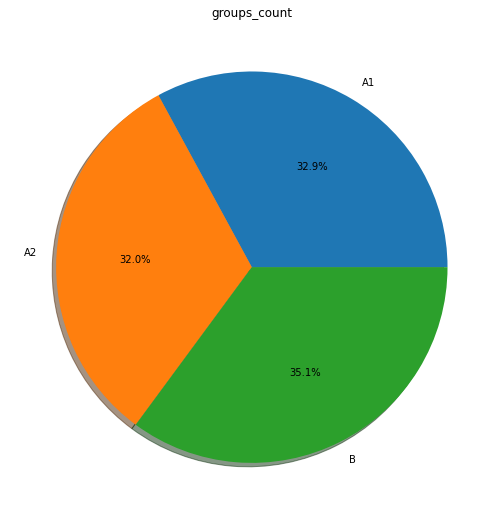

In [224]:
plt.figure(figsize=(16, 9))
plt.pie(group_pivot['event_name'], labels=['A1', 'A2', 'B'], autopct='%1.1f%%', shadow='true');
plt.title('groups_count')
plt.show()

Проверим, есть ли пересечения между группами

In [225]:
A1_filtered = data.query('group == "A1"')
A2_filtered = data.query('group == "A2"')
B_filtered = data.query('group == "B"')
print(A1_filtered.merge(A2_filtered, on='device_id').shape[0])
print(B_filtered.merge(A2_filtered, on='device_id').shape[0])
print(B_filtered.merge(A1_filtered, on='device_id').shape[0])

0
0
0


Видим, что пересечений нет

## Изучим воронку событий

In [226]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2828 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  240887 non-null  object        
 1   device_id   240887 non-null  int64         
 2   timestamp   240887 non-null  int64         
 3   datetime    240887 non-null  datetime64[ns]
 4   date        240887 non-null  datetime64[ns]
 5   group       240887 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 12.9+ MB


In [227]:
name_pivot = pd.pivot_table(data=data, 
                            index='event_name', 
                            values='device_id', 
                            aggfunc=['count', 'nunique'])
name_pivot.columns=['count', 'nunique']
name_pivot = name_pivot.sort_values(by='count', ascending=False)
name_pivot

,count,nunique
event_name,,
MainScreenAppear,117328,7419
OffersScreenAppear,46333,4593
CartScreenAppear,42303,3734
PaymentScreenSuccessful,33918,3539
Tutorial,1005,840


In [228]:
#plt.bar(x=range(len(name_pivot['nunique'])), y=name_pivot['nunique'], height=0.8)

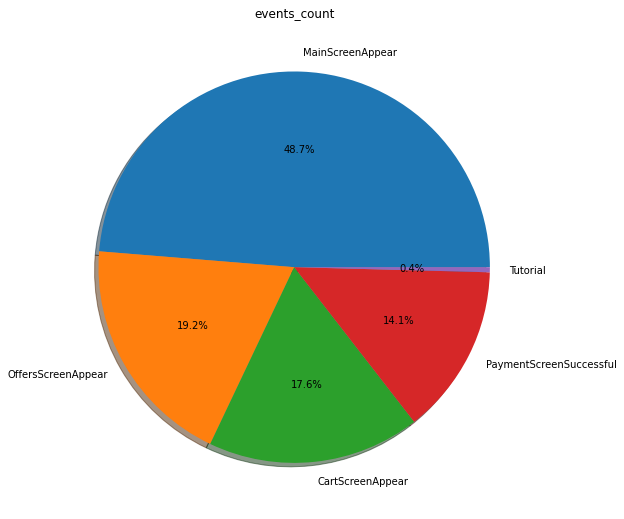

In [229]:
plt.figure(figsize=(16, 9))
plt.pie(name_pivot['count'],
        labels=name_pivot.index, autopct='%1.1f%%', shadow='true');
plt.title('events_count')
plt.show()

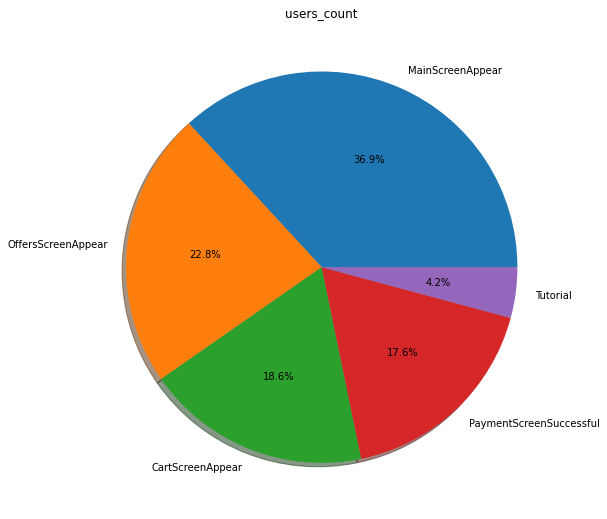

In [230]:
plt.figure(figsize=(16, 9))
plt.pie(name_pivot['nunique'],
        labels=name_pivot.index, autopct='%1.1f%%', shadow='true');
plt.title('users_count')
plt.show()

In [231]:
data.head()

,event_name,device_id,timestamp,datetime,date,group
2828,Tutorial,3737462046622621720,1564618048,2019-08-01 00:07:28,2019-08-01,A1
2829,MainScreenAppear,3737462046622621720,1564618080,2019-08-01 00:08:00,2019-08-01,A1
2830,MainScreenAppear,3737462046622621720,1564618135,2019-08-01 00:08:55,2019-08-01,A1
2831,OffersScreenAppear,3737462046622621720,1564618138,2019-08-01 00:08:58,2019-08-01,A1
2832,MainScreenAppear,1433840883824088890,1564618139,2019-08-01 00:08:59,2019-08-01,A2


Если предположить, что отображение главной страницы - это необходимый этап. То получим, что из 7551 уникальных юзеров 7419 совершили хотя бы одно событие

In [232]:
print(f'Доля таких пользователей {round(name_pivot["nunique"][0]/data["device_id"].nunique(), 3)}')

Доля таких пользователей 0.985


Я думаю, события происходят в таком порядке: Главный экран, Окно предложений, Корзина, Успешная оплата. Обучение не является обязательным этапом, некоторые клиенты могут обращаться к нему в случае затруднений

In [233]:
funnel = [name_pivot['nunique'][i+1]/name_pivot['nunique'][i] for i in range(len(name_pivot['nunique']) - 1)]

In [234]:
funnel = funnel[:-1]

In [235]:
funnel

[0.6190861302062273, 0.8129762682342695, 0.9477771826459561]

In [236]:
index = ['Main to Offers', 'Offers to Cart', 'Cart to Payment']
funnel_df = pd.DataFrame(data=funnel, index=index, columns=['conversion'])
funnel_df

,conversion
Main to Offers,0.619086
Offers to Cart,0.812976
Cart to Payment,0.947777


Заметим, что больше всего пользователей теряется при переходе с главной страницы на страницу заказа.

In [237]:
print(f'От первого звонка до оплаты доходит {round(name_pivot["nunique"][3]/name_pivot["nunique"][0], 3)} клиентов')

От первого звонка до оплаты доходит 0.477 клиентов


In [238]:
data_funnel = dict(
    number=name_pivot['count'][:-1],
    stage=name_pivot.index[:-1])
fig = px.funnel(data_funnel, x='number', y='stage', title='funnel')
fig.show()

## Изучим результаты эксперимента

In [239]:
group_pivot = pd.pivot_table(data=data, index='group', values='event_name', aggfunc='count')
group_pivot

,event_name
group,
A1,79302
A2,77022
B,84563


In [240]:
data.head()

,event_name,device_id,timestamp,datetime,date,group
2828,Tutorial,3737462046622621720,1564618048,2019-08-01 00:07:28,2019-08-01,A1
2829,MainScreenAppear,3737462046622621720,1564618080,2019-08-01 00:08:00,2019-08-01,A1
2830,MainScreenAppear,3737462046622621720,1564618135,2019-08-01 00:08:55,2019-08-01,A1
2831,OffersScreenAppear,3737462046622621720,1564618138,2019-08-01 00:08:58,2019-08-01,A1
2832,MainScreenAppear,1433840883824088890,1564618139,2019-08-01 00:08:59,2019-08-01,A2


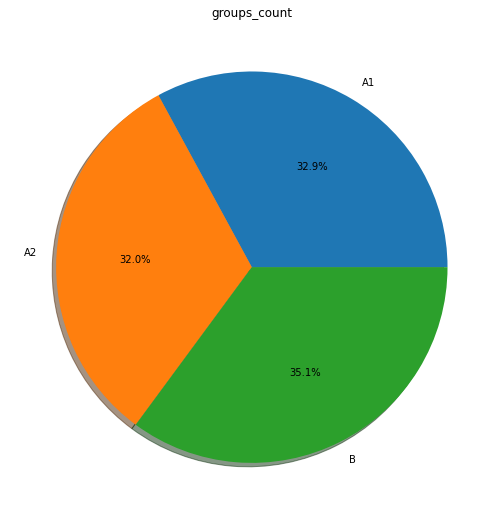

In [241]:
plt.figure(figsize=(16, 9))
plt.pie(group_pivot['event_name'], labels=['A1', 'A2', 'B'], autopct='%1.1f%%', shadow='true');
plt.title('groups_count')
plt.show()

In [242]:
data.head()

,event_name,device_id,timestamp,datetime,date,group
2828,Tutorial,3737462046622621720,1564618048,2019-08-01 00:07:28,2019-08-01,A1
2829,MainScreenAppear,3737462046622621720,1564618080,2019-08-01 00:08:00,2019-08-01,A1
2830,MainScreenAppear,3737462046622621720,1564618135,2019-08-01 00:08:55,2019-08-01,A1
2831,OffersScreenAppear,3737462046622621720,1564618138,2019-08-01 00:08:58,2019-08-01,A1
2832,MainScreenAppear,1433840883824088890,1564618139,2019-08-01 00:08:59,2019-08-01,A2


,count,nunique
event_name,,
MainScreenAppear,37676,2450
OffersScreenAppear,14767,1542
CartScreenAppear,14690,1266
PaymentScreenSuccessful,11852,1200
Tutorial,317,278


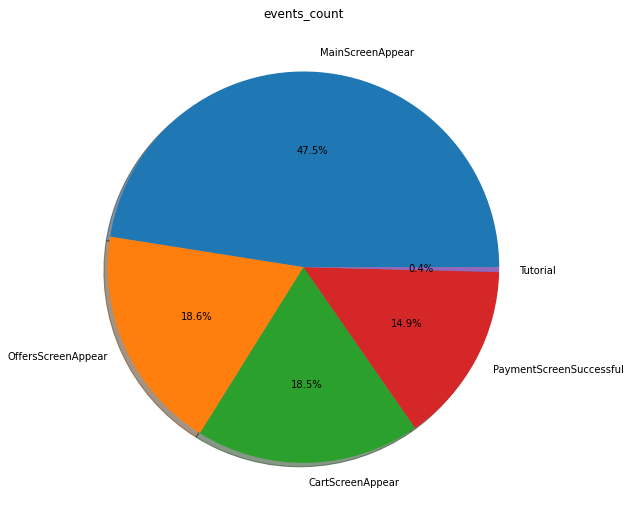

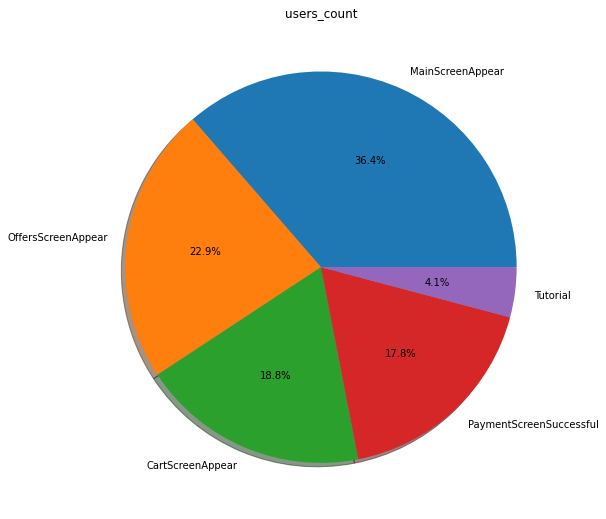

In [243]:

name_pivotA1 = pd.pivot_table(data=data.query('group == "A1"'), 
                    index='event_name', 
                    values='device_id', 
                    aggfunc=['count', 'nunique'])
name_pivotA1.columns=['count', 'nunique']
name_pivotA1 = name_pivotA1.sort_values(by='count', ascending=False)
display(name_pivotA1)
plt.figure(figsize=(16, 9))
plt.pie(name_pivotA1['count'],
        labels=name_pivotA1.index, autopct='%1.1f%%', shadow='true');
plt.title('events_count')
plt.figure(figsize=(16, 9))
plt.pie(name_pivotA1['nunique'],
        labels=name_pivotA1.index, autopct='%1.1f%%', shadow='true');
plt.title('users_count')
plt.show()

,count,nunique
event_name,,
MainScreenAppear,39090,2476
OffersScreenAppear,15179,1520
CartScreenAppear,12434,1238
PaymentScreenSuccessful,9981,1158
Tutorial,338,283


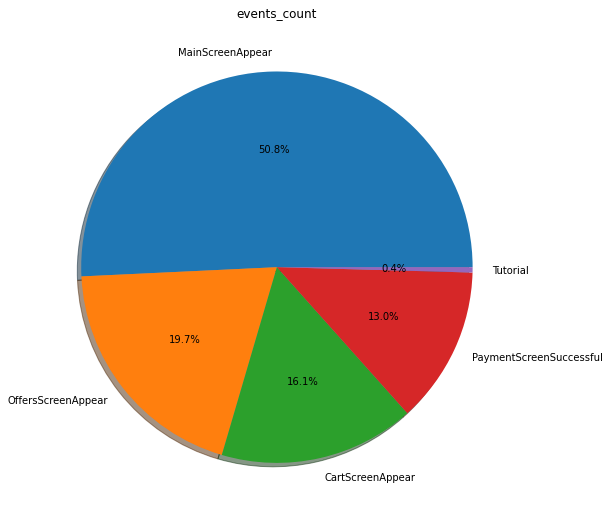

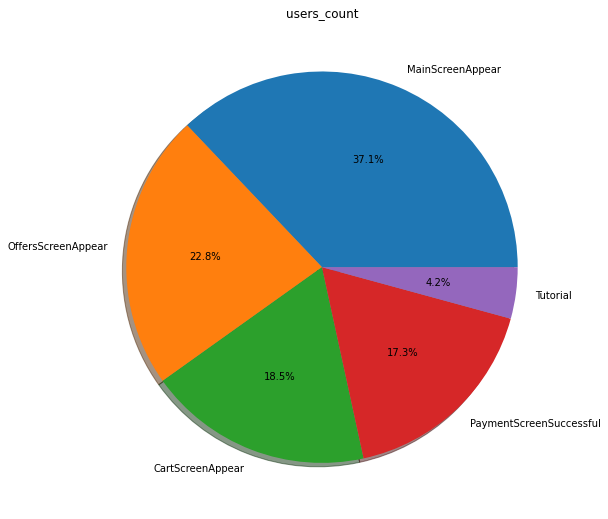

In [244]:
name_pivotA2 = pd.pivot_table(data=data.query('group == "A2"'), 
                    index='event_name', 
                    values='device_id', 
                    aggfunc=['count', 'nunique'])
name_pivotA2.columns=['count', 'nunique']
name_pivotA2 = name_pivotA2.sort_values(by='count', ascending=False)
display(name_pivotA2)
plt.figure(figsize=(16, 9))
plt.pie(name_pivotA2['count'],
        labels=name_pivotA2.index, autopct='%1.1f%%', shadow='true');
plt.title('events_count')
plt.figure(figsize=(16, 9))
plt.pie(name_pivotA2['nunique'],
        labels=name_pivotA2.index, autopct='%1.1f%%', shadow='true');
plt.title('users_count')
plt.show()

,count,nunique
event_name,,
MainScreenAppear,40562,2493
OffersScreenAppear,16387,1531
CartScreenAppear,15179,1230
PaymentScreenSuccessful,12085,1181
Tutorial,350,279


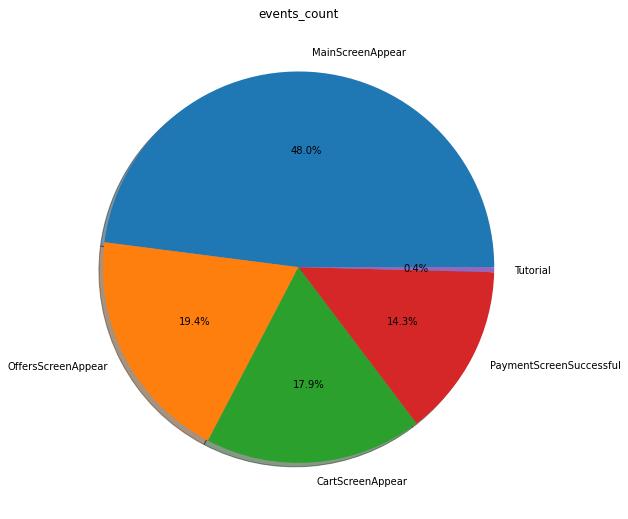

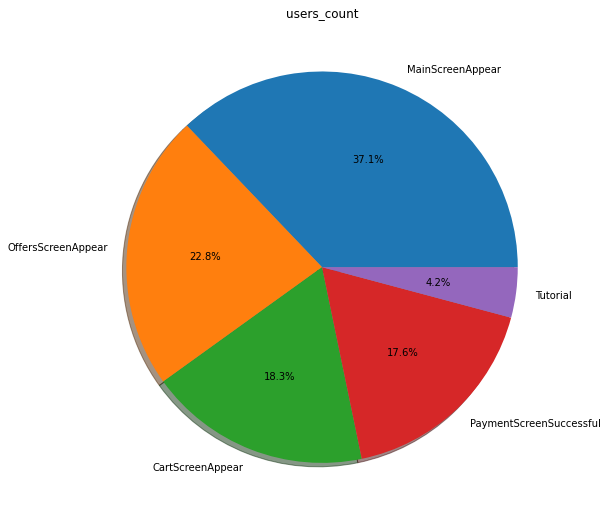

In [245]:
name_pivotB = pd.pivot_table(data=data.query('group == "B"'), 
                    index='event_name', 
                    values='device_id', 
                    aggfunc=['count', 'nunique'])
name_pivotB.columns=['count', 'nunique']
name_pivotB = name_pivotB.sort_values(by='count', ascending=False)
display(name_pivotB)
plt.figure(figsize=(16, 9))
plt.pie(name_pivotB['count'],
        labels=name_pivotB.index, autopct='%1.1f%%', shadow='true');
plt.title('events_count')
plt.figure(figsize=(16, 9))
plt.pie(name_pivotB['nunique'],
        labels=name_pivotB.index, autopct='%1.1f%%', shadow='true');
plt.title('users_count')
plt.show()

Проверим статистическое различие гипотез при помощи непараметрического теста Манна-Уитни

,count,nunique
event_name,,
MainScreenAppear,76766,4926
OffersScreenAppear,29946,3062
CartScreenAppear,27124,2504
PaymentScreenSuccessful,21833,2358
Tutorial,655,561


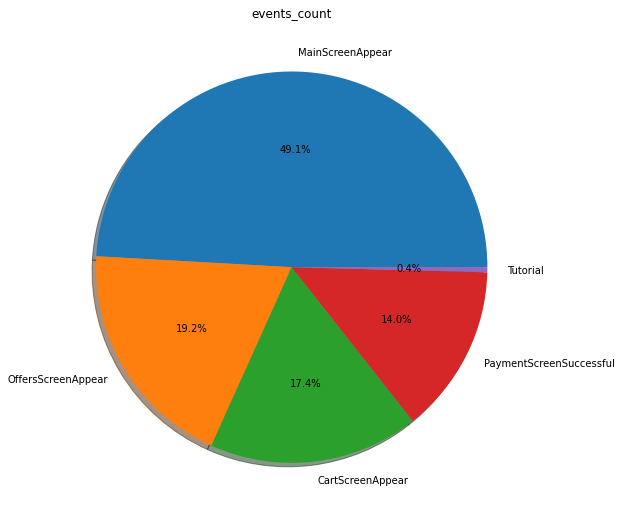

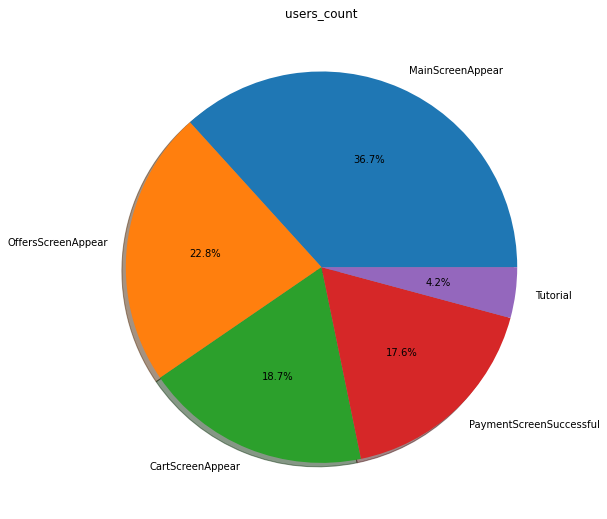

In [246]:
name_pivotA = pd.pivot_table(data=data.query('group == "A1" or group == "A2"'), 
                    index='event_name', 
                    values='device_id', 
                    aggfunc=['count', 'nunique'])
name_pivotA.columns=['count', 'nunique']
name_pivotA = name_pivotA.sort_values(by='count', ascending=False)
display(name_pivotA)
plt.figure(figsize=(16, 9))
plt.pie(name_pivotA['count'],
        labels=name_pivotA.index, autopct='%1.1f%%', shadow='true');
plt.title('events_count')
plt.figure(figsize=(16, 9))
plt.pie(name_pivotA['nunique'],
        labels=name_pivotA.index, autopct='%1.1f%%', shadow='true');
plt.title('users_count')
plt.show()

In [247]:
user_pivotB = pd.pivot_table(data=data.query('group == "B"'), 
                    index='device_id', 
                    values='event_name', 
                    aggfunc=['count'])
user_pivotB.columns=['count']
user_pivotB = user_pivotB.sort_values(by='count', ascending=False)
display(user_pivotB)


,count
device_id,
6304868067479728361,2307
6932517045703054087,1439
4713748699910253089,824
3521696259961091617,702
3610536745613892312,661
...,...
1201821821994248592,1
8188293597840107588,1
8186183676377809366,1


In [248]:
user_pivotA1 = pd.pivot_table(data=data.query('group == "A1"'), 
                    index='device_id', 
                    values='event_name', 
                    aggfunc=['count'])
user_pivotA1.columns=['count']
user_pivotA1 = user_pivotA1.sort_values(by='count', ascending=False)
display(user_pivotA1)


,count
device_id,
197027893265565660,1996
3337471580007169353,1186
7738058666231999878,888
1055544042902443290,853
8118046800480174342,755
...,...
1223708690315846789,1
986776646643071594,1
953362203797229321,1


In [249]:
user_pivotA2 = pd.pivot_table(data=data.query('group == "A2"'), 
                    index='device_id', 
                    values='event_name', 
                    aggfunc=['count'])
user_pivotA2.columns=['count']
user_pivotA2 = user_pivotA2.sort_values(by='count', ascending=False)
display(user_pivotA2)


,count
device_id,
4623191541214045580,1768
1754140665440434215,1221
1989685320445148348,728
2768580714092136945,523
4257848154605915902,378
...,...
6192612340865921875,1
8005753485514903385,1
6936517579657223951,1


In [250]:
def z_test_iter(df1, df2, alpha):
    for i in range(len(df1.index) - 1):
        print(f'Вычисляем z критерий для {i+1} шага')
        successes = np.array([df1['count'][i+1], df2['count'][i+1]])
        trials = np.array([df1['count'][i], df2['count'][i]])
        z_test(successes, trials, alpha)

In [251]:
def z_test(successes, trials, alpha):
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )

In [252]:
z_test_iter(name_pivotA1, name_pivotA2, .1)

Вычисляем z критерий для 1 шага
p-значение:  0.30156092481921815
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Вычисляем z критерий для 2 шага
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница
Вычисляем z критерий для 3 шага
p-значение:  0.39710251244033623
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Вычисляем z критерий для 4 шага
p-значение:  0.0021312852874268984
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [253]:
z_test_iter(name_pivotB, name_pivotA2, .1)

Вычисляем z критерий для 1 шага
p-значение:  6.018696650178512e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница
Вычисляем z критерий для 2 шага
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница
Вычисляем z критерий для 3 шага
p-значение:  0.17634571420040723
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Вычисляем z критерий для 4 шага
p-значение:  0.03701081777846471
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [254]:
z_test_iter(name_pivotB, name_pivotA1, .1)

Вычисляем z критерий для 1 шага
p-значение:  0.0005800679101024553
Отвергаем нулевую гипотезу: между долями есть значимая разница
Вычисляем z критерий для 2 шага
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница
Вычисляем z критерий для 3 шага
p-значение:  0.02118344648652859
Отвергаем нулевую гипотезу: между долями есть значимая разница
Вычисляем z критерий для 4 шага
p-значение:  0.2978618110389517
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [255]:
z_test_iter(name_pivotB, name_pivotA, .1)

Вычисляем z критерий для 1 шага
p-значение:  3.5908870474887777e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница
Вычисляем z критерий для 2 шага
p-значение:  6.705747068735946e-14
Отвергаем нулевую гипотезу: между долями есть значимая разница
Вычисляем z критерий для 3 шага
p-значение:  0.030038707127272524
Отвергаем нулевую гипотезу: между долями есть значимая разница
Вычисляем z критерий для 4 шага
p-значение:  0.588919816475657
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Наблюдаем статистически значимое различие групп A1 и B на всех этапах клиентского пути. Между группами A2 и B на первых двух шагах. Между группами A1 и A2 на втором и четвертом шаге. 

Для проверки статистических гипотез я выбрал уровень значимости alpha = 0.1. Всего было выполнено 16 проверок, таким образом, примерно в 1-2 случаях получен ложный результат. Попробуем провести тесты с более низким уровнем значимости

In [256]:
z_test_iter(name_pivotA1, name_pivotA2, .05)

Вычисляем z критерий для 1 шага
p-значение:  0.30156092481921815
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Вычисляем z критерий для 2 шага
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница
Вычисляем z критерий для 3 шага
p-значение:  0.39710251244033623
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Вычисляем z критерий для 4 шага
p-значение:  0.0021312852874268984
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [257]:
z_test_iter(name_pivotB, name_pivotA2, .05)

Вычисляем z критерий для 1 шага
p-значение:  6.018696650178512e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница
Вычисляем z критерий для 2 шага
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница
Вычисляем z критерий для 3 шага
p-значение:  0.17634571420040723
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Вычисляем z критерий для 4 шага
p-значение:  0.03701081777846471
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [258]:
z_test_iter(name_pivotB, name_pivotA1, .05)

Вычисляем z критерий для 1 шага
p-значение:  0.0005800679101024553
Отвергаем нулевую гипотезу: между долями есть значимая разница
Вычисляем z критерий для 2 шага
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница
Вычисляем z критерий для 3 шага
p-значение:  0.02118344648652859
Отвергаем нулевую гипотезу: между долями есть значимая разница
Вычисляем z критерий для 4 шага
p-значение:  0.2978618110389517
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [259]:
z_test_iter(name_pivotA1, name_pivotA2, .01)

Вычисляем z критерий для 1 шага
p-значение:  0.30156092481921815
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Вычисляем z критерий для 2 шага
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница
Вычисляем z критерий для 3 шага
p-значение:  0.39710251244033623
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Вычисляем z критерий для 4 шага
p-значение:  0.0021312852874268984
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [260]:
z_test_iter(name_pivotB, name_pivotA2, .01)

Вычисляем z критерий для 1 шага
p-значение:  6.018696650178512e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница
Вычисляем z критерий для 2 шага
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница
Вычисляем z критерий для 3 шага
p-значение:  0.17634571420040723
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Вычисляем z критерий для 4 шага
p-значение:  0.03701081777846471
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [261]:
z_test_iter(name_pivotB, name_pivotA1, .01)

Вычисляем z критерий для 1 шага
p-значение:  0.0005800679101024553
Отвергаем нулевую гипотезу: между долями есть значимая разница
Вычисляем z критерий для 2 шага
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница
Вычисляем z критерий для 3 шага
p-значение:  0.02118344648652859
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Вычисляем z критерий для 4 шага
p-значение:  0.2978618110389517
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Я считаю, что для обеспечения достаточной точности результата можно использовать z-критерий с уровнем значимости alpha = 0.05

Теперь проведем тесты с объединенной А группой

Построим совмещенные графики для групп А и В

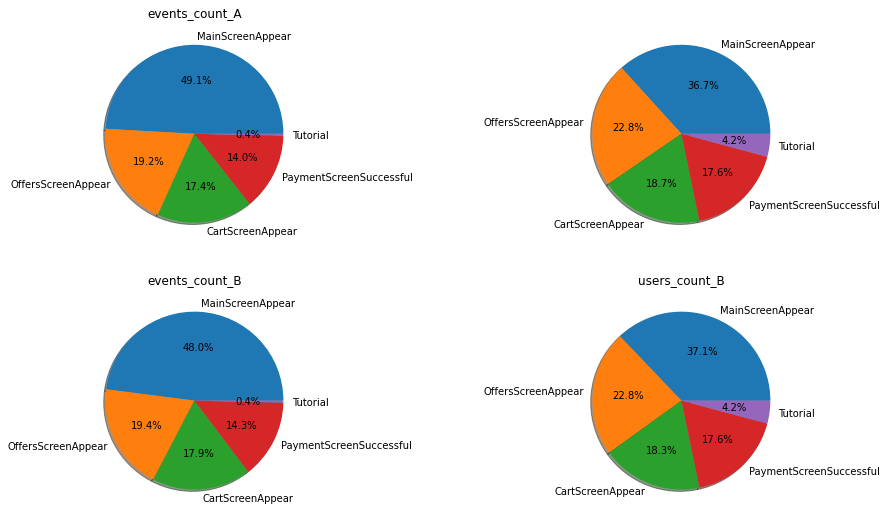

In [262]:
plt.figure(figsize=(16 ,9))
plt.subplot(2, 2, 1)
plt.pie(name_pivotA['count'],
        labels=name_pivotA.index, autopct='%1.1f%%', shadow='true');
plt.title('events_count_A')
plt.subplot(2, 2, 2)
plt.pie(name_pivotA['nunique'],
        labels=name_pivotA.index, autopct='%1.1f%%', shadow='true');
plt.subplot(2, 2, 3)
plt.title('users_count_A')
plt.pie(name_pivotB['count'],
        labels=name_pivotB.index, autopct='%1.1f%%', shadow='true');
plt.title('events_count_B')
plt.subplot(2, 2, 4)
plt.pie(name_pivotB['nunique'],
        labels=name_pivotB.index, autopct='%1.1f%%', shadow='true');
plt.title('users_count_B')
plt.show()

In [263]:
z_test_iter(name_pivotB, name_pivotA, .05)

Вычисляем z критерий для 1 шага
p-значение:  3.5908870474887777e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница
Вычисляем z критерий для 2 шага
p-значение:  6.705747068735946e-14
Отвергаем нулевую гипотезу: между долями есть значимая разница
Вычисляем z критерий для 3 шага
p-значение:  0.030038707127272524
Отвергаем нулевую гипотезу: между долями есть значимая разница
Вычисляем z критерий для 4 шага
p-значение:  0.588919816475657
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [264]:
z_test_iter(name_pivotB, name_pivotA, .01)

Вычисляем z критерий для 1 шага
p-значение:  3.5908870474887777e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница
Вычисляем z критерий для 2 шага
p-значение:  6.705747068735946e-14
Отвергаем нулевую гипотезу: между долями есть значимая разница
Вычисляем z критерий для 3 шага
p-значение:  0.030038707127272524
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Вычисляем z критерий для 4 шага
p-значение:  0.588919816475657
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Обнаружили статистически значимое различие между объединенной группой А и группой В

## Вывод

В ходе работы мы провели анализ результатов А/В теста, в ходе которого выяснили, что существует статистически значимое различие между группами А и В на всех этапах воронки, кроме справочника. Так, доля события Появление главного экрана стала ниже, а доля событий Экран предложений, Корзина и Успешная оплата выросли. Таким образом, новый дизайн шрифтов поспособствовал росту конверсии пользователей в продажу.